# CS-GY 6953 Deep Learning Mini-Project Ensembling

Task: Building a ResNet model on CIFAR-10 with a constraint of 5 million parameters maximum.

In this notebook, when I refer to a paper, it is about the ResNet paper: https://arxiv.org/abs/1512.03385 <br>
Codes are developed based on the excellent work here: https://github.com/kuangliu/pytorch-cifar

## 1. Possible Improvement Ideas
After having a discussion, we decided to focus on the following 7 ideas and see if the performance will improve.
* Deeper Network with Less Channels <br>
According to the paper, the ResNet have an advantage of successfully learning very deep networks compared with networks without the skip-connection. As the number of parameters is limited in this assignment, we need to have less channels in each layers, use smaller kernels, or think of other approach to make the number of parameters in each layer smaller. <br>
* Trying Different Optimization Approaches <br>
The original implementation uses the Stochastic Gradient Descent as an optimizer and the CosineAnnealing for learning rate scheduler. It is worth trying using different optimizers such as Adam as well as manually controlling the learning rate. <br>
* Ensembling <br>
In our first attempt, one model achieves approx. 86% accuracy with only 2 million parameters. So, it may be interesting to develop multiple small models and ensemble the results. <br>
* Increasing Fully-Connected Layers <br>
The original model has only one FC layer. Though the FC layers tend to use lots of parameters, this might give better predictions.
* Modifying the Kernel Size of Skip-Connection <br>
The original model uses $2 \times 2$ filter in the skip-connection but changing this may result in different results. <br>
* Removing the Kernel in Skip-Connection <br>
The paper suggests the idea of identity mapping with zero-padding for the skip-connection.
* Using Regularizers; $\ell_1$, $\ell_2$, Dropout, etc. <br>
Since the main objective of the regularizers is to address the overfitting, we will work on this approach after seeing the overfitting. <br>
<br>
In this notebook, <b> I will implement the ensembling method </b> , developing several small models and seeing if combining them results in better prediction accuracy. Moreover, <b> I will also implement the learning rate controller </b>.

## 2. Ensembling
The high-level idea of ensembling is to constructing a strong predictor by combining multiple weak or mediocre predictors. In ensembling, each small predictors separately make predictions, then these predictions are aggregated to output one final prediction. <br>
There are several ways for the aggregation. One possible choice is voting. Since we work on 10-class classification task, each small predictor gives a prediction and we simply choose the majority votes. If we use this approach, we also need to think about the tie-breaking procedure. Another would be averaging, where each predictor provides an output of Softmax function. Then, the aggregation step adds them up and picks the one with the highest probability. There are many other schemes such as introducing weights among predictors, deploying another neural network on top of the small predictors, and so on. 

## 3. Learning Rate Controlling
In the ResNet paper, the authors fixed the learning rate at 0.1 at the beginning, and divided it by 10 at 32,000 and 48,000 iterations. Everytime the learning rate got smaller, we see a sharp decrease in the error rate. In the FirstAttempt and NoParamSkip notebooks, I used the CosineAnnealing learning rate scheduler for no reason. So, in this notebook, I will set the learning rate to 0.1, and divide it by 10 when there are no improvements in test accuracy. <br>
To put this idea in my model, I will use ReduceLROnPlateau: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau <br>
To change the learning rate by the test accuracy, the parameters will be set as <br>
* mode: "max"
* factor: 0.1 (following the paper's procedure.)
* patience: 10 (same as its default value. I may change this later.)

## 4. Preparation
Importing the libraries, setting the dataset, defining functions, etc.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torchsummary import summary

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
# There are more functions for augmentation.
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data',train=False, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"The device is {device}.")

The device is cuda.


In [4]:
class BasicBlock(nn.Module): # A residual block with 2 convolutional layers and a skip connection.
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1, identity_skip=False): # Add identity_skip parameter.
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes,      # Number of channels in the input image
                               planes,         # Number of output channels
                               kernel_size=3,  # Size of the convolution filter
                               stride=stride,  # Stride of the convolution
                               padding=1,      # Padding added to all four sides of the input, int or {'valid', 'same'}, etc.
                               # padding_mode={'zeros', 'reflect', 'replicate', 'circular'}
                               bias=False)     # If true, adds a learnable bias ot the output.
        self.bn1 = nn.BatchNorm2d(planes)      # Other parameters include eps, momentum, affine, etc.
                                               # affine=True: affine parameters being learnable.
        self.conv2 = nn.Conv2d(planes, 
                               planes, 
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()        # A sequentil wrapper of layers.
        # If the dimentions of skip connection input and output don't match, do the following.
        # As an alternative solution, zero-padding is also proposed in the paper.
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, 
                                                    self.expansion*planes, 
                                                    kernel_size=1, 
                                                    stride=stride, 
                                                    bias=False),
                                          nn.BatchNorm2d(self.expansion*planes))
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [5]:
def train(epoch):
    if (epoch+1) % 10 == 0:
        print('\nEpoch: %d'%epoch)
    model.train()
    train_loss = 0
    correct, total = 0, 0
    for (inputs, targets) in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    acc = correct/total*100
    train_loss /= total
    if (epoch+1) % 10 == 0:
        print(f"Train | Loss: {round(train_loss, 4)} | Acc: {round(acc, 2)}")
    train_losses.append(train_loss)
    train_accs.append(acc)

def test(epoch):
    global train_losses, test_losses, train_accs, test_accs, best_acc, best_model
    model.eval()
    test_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for (inputs, targets) in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = correct/total*100
    test_loss /= total
    if (epoch+1) % 10 == 0:
        print(f"Test  | Loss: {round(test_loss, 4)} | Acc: {round(acc, 2)}")
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    if acc > best_acc:
        best_model = model.state_dict()
        best_acc = acc

## 5. Building Models 1 -- five models ensembling --
As the first attempt, I will create 5 models, each with 1 million parameters.

In [35]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32
        
        self.conv1 = nn.Conv2d(3, 32, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 96, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 120, num_blocks[3], stride=2)
        self.linear = nn.Linear(120*block.expansion, num_classes)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes*block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

Each model has the following structure. As we will create 5 models, the number of parameters in total will be 4,937,010 slightly less than 5 million.

In [18]:
model_example = ResNet(BasicBlock, [2,2,2,2]).to(device)
summary(model_example, (3, 32, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1, 64,

In [22]:
models = {}
if not os.path.isdir('checkpoint_ensemble5'):
    os.mkdir('checkpoint_ensemble5')
    torch.save(models, './checkpoint_ensemble5/ckpt.pth')

Note: For model1 and model2, I set the patience to 10. For model3 I set it to 20. For model4, and model5, I set it to 15.

In [23]:
num_models = 5

models = torch.load('./checkpoint_ensemble5/ckpt.pth')

for i in range(len(models), num_models):
    print(f"Training {i+1}-th model...")
    model = ResNet(BasicBlock, [2,2,2,2]).to(device)
    
    if device == 'cuda':
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                          lr=0.1, 
                          momentum=0.9, 
                          weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=15)
    
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    lrs = []
    
    num_epochs = 100
    best_acc = 0
    best_model = model.state_dict()
    models["model"+str(i+1)] = {}
    for epoch in range(num_epochs):
        train(epoch)
        test(epoch)
        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step(test_accs[-1])
    models["model"+str(i+1)]["model"] = best_model
    models["model"+str(i+1)]["train_loss"] = train_losses
    models["model"+str(i+1)]["test_loss"] = test_losses
    models["model"+str(i+1)]["train_acc"] = train_accs
    models["model"+str(i+1)]["test_acc"] = test_accs
    models["model"+str(i+1)]["lr"] = lrs
    models["model"+str(i+1)]["epoch"] = epoch
    torch.save(models, './checkpoint_ensemble5/ckpt.pth')
    print("\n")

Training 4-th model...

Epoch: 9
Train | Loss: 0.0042 | Acc: 81.55
Test  | Loss: 0.0059 | Acc: 74.91

Epoch: 19
Train | Loss: 0.0035 | Acc: 84.65
Test  | Loss: 0.0044 | Acc: 80.83

Epoch: 29
Train | Loss: 0.0033 | Acc: 85.67
Test  | Loss: 0.0046 | Acc: 80.14

Epoch: 39
Train | Loss: 0.0032 | Acc: 85.96
Test  | Loss: 0.0053 | Acc: 78.09

Epoch: 49
Train | Loss: 0.0012 | Acc: 94.67
Test  | Loss: 0.002 | Acc: 91.97

Epoch: 59
Train | Loss: 0.0008 | Acc: 96.57
Test  | Loss: 0.0022 | Acc: 91.56

Epoch: 69
Train | Loss: 0.0007 | Acc: 96.79
Test  | Loss: 0.0024 | Acc: 90.83

Epoch: 79
Train | Loss: 0.0002 | Acc: 99.17
Test  | Loss: 0.0019 | Acc: 93.15

Epoch: 89
Train | Loss: 0.0002 | Acc: 99.4
Test  | Loss: 0.002 | Acc: 93.22

Epoch: 99
Train | Loss: 0.0001 | Acc: 99.57
Test  | Loss: 0.002 | Acc: 93.13


Training 5-th model...

Epoch: 9
Train | Loss: 0.0041 | Acc: 81.88
Test  | Loss: 0.0088 | Acc: 68.09

Epoch: 19
Train | Loss: 0.0035 | Acc: 84.57
Test  | Loss: 0.0046 | Acc: 80.84

Epoch: 29

The visualization of training is as follows.

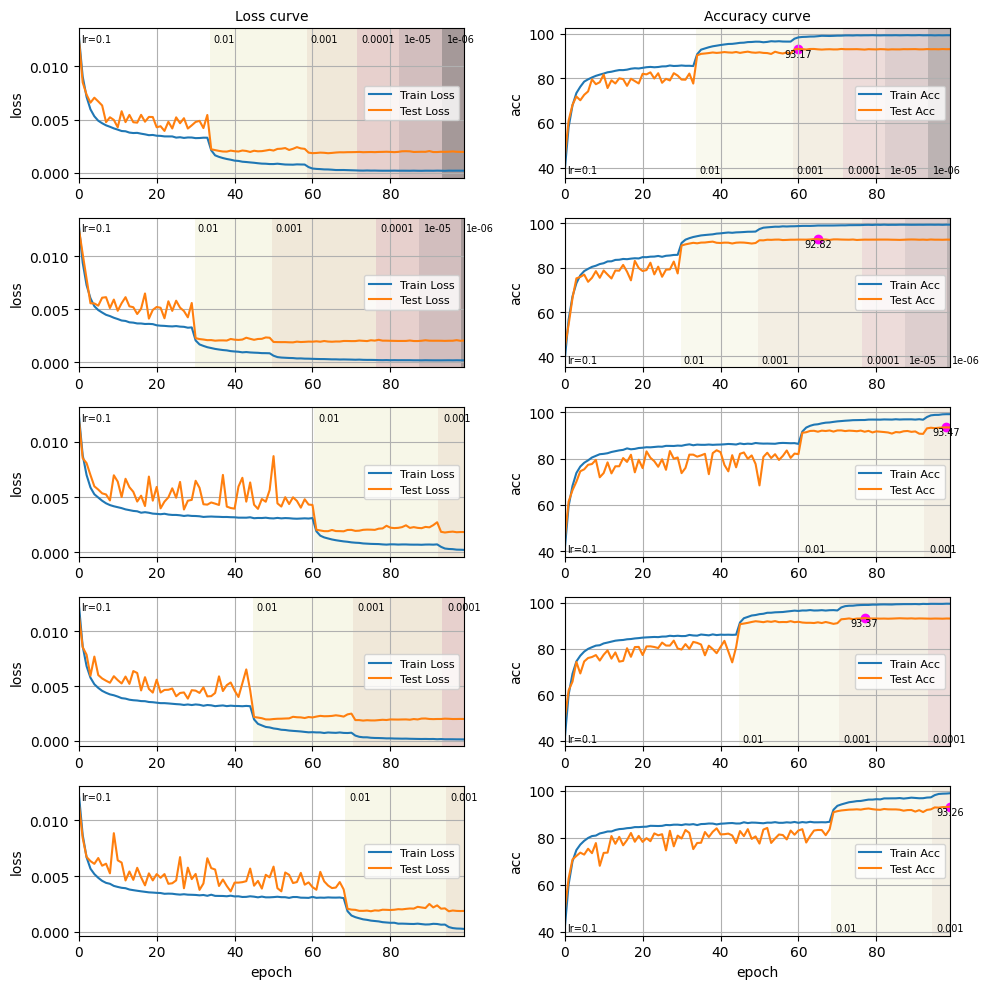

In [7]:
num_models = 5
num_epochs = 100

models = torch.load('./checkpoint_ensemble5/ckpt.pth', map_location=device)
xax = range(num_epochs)
fig, axs = plt.subplots(num_models, 2, figsize=(10,10))
for i in range(num_models):
    axs[i, 0].plot(xax, models["model"+str(i+1)]["train_loss"], label="Train Loss")
    axs[i, 0].plot(xax, models["model"+str(i+1)]["test_loss"], label="Test Loss")
    if i == 0:
        axs[i, 0].set_title('Loss curve', fontsize=10)
    if i == num_models-1:
        axs[i, 0].set_xlabel('epoch')
    axs[i, 0].set_ylabel('loss')
    axs[i, 0].grid()
    axs[i, 0].legend(loc="center right", fontsize=8)
    lr = models["model"+str(i+1)]["lr"]
    axs[i, 0].pcolorfast(xax, axs[i, 0].get_ylim(), np.log(np.array(lr))[np.newaxis], cmap="pink", alpha=0.4, vmax=np.log(1e-1), vmin=np.log(1e-6))
    l = 1
    for j in xax:
        if lr[j] != l:
            l = lr[j]
            if j == 0:
                axs[i, 0].text(j+0.5, axs[i, 0].get_ylim()[1]-0.0005, f"lr={round(l,6)}", fontsize=7, va="top")
            else:
                axs[i, 0].text(j+0.5, axs[i, 0].get_ylim()[1]-0.0005, f"{round(l,6)}", fontsize=7, va="top")
            
    axs[i, 1].plot(xax, models["model"+str(i+1)]["train_acc"], label="Train Acc")
    axs[i, 1].plot(xax, models["model"+str(i+1)]["test_acc"], label="Test Acc")
    best_epoch, best_val = np.argmax(models["model"+str(i+1)]["test_acc"]), max(models["model"+str(i+1)]["test_acc"])
    axs[i, 1].scatter(best_epoch, best_val, marker="o", c="magenta")
    axs[i, 1].text(best_epoch, best_val, round(best_val, 2), va="top", ha="center", fontsize=7)
    if i == 0:
        axs[i, 1].set_title('Accuracy curve', fontsize=10)
    if i == num_models-1:
        axs[i, 1].set_xlabel('epoch')
    axs[i, 1].set_ylabel('acc')
    axs[i, 1].grid()
    axs[i, 1].legend(loc="center right", fontsize=8)
    lr = models["model"+str(i+1)]["lr"]
    axs[i, 1].pcolorfast(xax, axs[i, 1].get_ylim(), np.log(np.array(lr))[np.newaxis], cmap="pink", alpha=0.3, vmax=np.log(1e-1), vmin=np.log(1e-6))
    l = 1
    for j in xax:
        if lr[j] != l:
            l = lr[j]
            if j == 0:
                axs[i, 1].text(j+0.5, axs[i, 1].get_ylim()[0]+1, f"lr={round(l,6)}", fontsize=7, va="bottom")
            else:
                axs[i, 1].text(j+0.5, axs[i, 1].get_ylim()[0]+1, f"{round(l,6)}", fontsize=7, va="bottom")
fig.tight_layout()
fig.show()

## 6. Ensembling 1 -- five models ensembling --
Firstly, I use the majority vote for ensembling. If the tie happens, I pick one candidate uniformly at random. For computing the accuracy, I will take the expectation.

In [38]:
models = torch.load('./checkpoint_ensemble5/ckpt.pth', map_location=device)
model = ResNet(BasicBlock, [2,2,2,2]).to(device)
if device=='cuda':
    model = torch.nn.DataParallel(model)
pred_dict, target_dict = {}, {}
pred_dict["train"], pred_dict["test"] = {}, {}
target_dict["train"], target_dict["test"] = np.array([], dtype=np.int8), np.array([], dtype=np.int8)
for i in range(num_models):
    pred_dict["train"]["model"+str(i+1)] = np.array([], dtype=np.float64).reshape(0,10)
    pred_dict["test"]["model"+str(i+1)] = np.array([], dtype=np.float64).reshape(0,10)
with torch.no_grad():
    for (inputs, targets) in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        for i in range(num_models):
            model.load_state_dict(models["model"+str(i+1)]["model"])
            model.eval()
            outputs = torch.nn.Softmax(dim=1)(model(inputs))
            pred_dict["train"]["model"+str(i+1)] = np.vstack([pred_dict["train"]["model"+str(i+1)], outputs.cpu().detach().numpy()])
            if i == 0:
                target_dict["train"] = np.hstack([target_dict["train"], targets.cpu().detach().numpy()])
    for (inputs, targets) in testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        for i in range(num_models):
            model.load_state_dict(models["model"+str(i+1)]["model"])
            model.eval()
            outputs = torch.nn.Softmax(dim=1)(model(inputs))
            pred_dict["test"]["model"+str(i+1)] = np.vstack([pred_dict["test"]["model"+str(i+1)], outputs.cpu().detach().numpy()])
            if i == 0:
                target_dict["test"] = np.hstack([target_dict["test"], targets.cpu().detach().numpy()])

In [39]:
from collections import Counter
import random
train_pred = np.array([], dtype=np.int8).reshape(0,50000)
test_pred = np.array([], dtype=np.int8).reshape(0,10000)
for i in range(num_models):
    train_pred = np.vstack([train_pred, np.argmax(pred_dict["train"]["model"+str(i+1)], axis=1)])
    test_pred = np.vstack([test_pred, np.argmax(pred_dict["test"]["model"+str(i+1)], axis=1)])
train_vote, test_vote = [], []
train_ties, test_ties = {"false": 0, "2": 0, "5": 0}, {"false": 0, "2": 0, "5": 0}
train_rand_choice, test_rand_choice = [], []
for i in range(len(train_pred[0])):
    c = Counter(train_pred[:, i]).most_common(num_models)
    if len(c) > 1 and c[0][1] == c[1][1]:
        cand = []
        for cnt in c:
            if cnt[1] == c[0][1]:
                cand.append(cnt[0])
        if target_dict["train"][i] in cand:
            train_ties[str(len(cand))] += 1
        else:
            train_ties["false"] += 1
        train_vote.append(-1)
        train_rand_choice.append(random.choice(cand))
    else:
        train_vote.append(c[0][0])
for i in range(len(test_pred[0])):
    c = Counter(test_pred[:, i]).most_common(num_models)
    if len(c) > 1 and c[0][1] == c[1][1]:
        cand = []
        for cnt in c:
            if cnt[1] == c[0][1]:
                cand.append(cnt[0])
        if target_dict["test"][i] in cand:
            test_ties[str(len(cand))] += 1
        else:
            test_ties["false"] += 1
        test_vote.append(-1)
        test_rand_choice.append(random.choice(cand))
    else:
        test_vote.append(c[0][0])
print(f"The number of ties in the training data: {sum(train_ties.values())}")
print(f"The number of ties in the test data: {sum(test_ties.values())}")
train_vote = np.array(train_vote)
test_vote = np.array(test_vote)
num_train_true = sum(train_vote==target_dict["train"]) + train_ties["2"] / 2 + train_ties["5"] / 5
num_test_true = sum(test_vote==target_dict["test"]) + test_ties["2"] / 2 + test_ties["5"] / 5
train_acc = num_train_true / len(train_vote) * 100
test_acc = num_test_true / len(test_vote) * 100
print(f"The training accuracy in expectation: {round(train_acc, 2)}%")
print(f"The test accuracy in expectation: {round(test_acc, 2)}%")
train_vote[train_vote==-1] = train_rand_choice
test_vote[test_vote==-1] = test_rand_choice

The number of ties in the training data: 8
The number of ties in the test data: 79
The training accuracy in expectation: 99.95%
The test accuracy in expectation: 94.41%


I got a very strong result of <b>94.41%</b> accuracy on the test set. The 5 small predictors are already powerful with test accuracy of 93.17%, 92.82%, 93.47%, 93.38%, and 93.26%, the ensembling push us to the next level. One possible question at this point would be what happens if we use the regularizations as we have near 100% accuracy on the training set while having 7% of gap between training and test accuracy. This will be covered in the next experiment. Another question would be how these predictors make mistakes. Are 5 predictors making similar mistakes? In other words, are there very difficult images in the test set that all 5 predictors are fooled? Or even when the outputs of the ensembling are false, some predictors give a right prediction? I work on this question in the following.

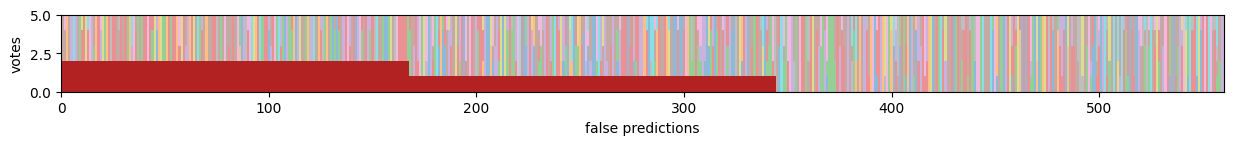

The total number of incorrectedly classified test images: 561
  Two predictors give correct prediction: 168
    142 cases lost by 2, 3
    26 cases lost by 2, 2, 1
  One predictor give correct prediction: 177
    97 cases lost by 1, 4
    45 cases lost by 1, 3, 1
    22 cases lost by 1, 2, 2
    12 cases lost by 1, 2, 1, 1
    1 cases lost by 1, 1, 1, 1, 1
  No predictor give correct prediction: 216
    120 cases lost by 0, 5
    43 cases lost by 0, 4, 1
    33 cases lost by 0, 3, 2
    12 cases lost by 0, 3, 1, 1
    7 cases lost by 0, 2, 2, 1
    1 cases lost by 0, 2, 1, 1, 1


In [40]:
false_cases = np.transpose(test_pred[:, test_vote!=target_dict["test"]])
true_labels = target_dict["test"][test_vote!=target_dict["test"]]
num_true = []
for i in range(len(false_cases)):
    num_true.append(sum(false_cases[i]==true_labels[i]))
num_true = np.array(num_true)
false_cases = false_cases[np.flip(np.argsort(num_true)), :]
true_labels = true_labels[np.flip(np.argsort(num_true))]
plot_arr = np.zeros((11, len(false_cases)))
for i in range(len(false_cases)):
    for elem in false_cases[i]:
        if elem == true_labels[i]:
            plot_arr[0, i] += 1
        else:
            plot_arr[elem+1, i] += 1

xax = np.arange(len(plot_arr[0]))
plt.figure(figsize=(15,1))
plt.bar(xax, plot_arr[0, :], width=1.0, label="True", color="firebrick")
for i in range(10):
    plt.bar(xax, plot_arr[i+1, :], width=1.0, bottom=np.sum(plot_arr[:i+1,:], axis=0), label=str(i), alpha=0.5)
plt.xlim([xax[0], xax[-1]])
plt.xlabel("false predictions")
plt.ylabel("votes")
plt.show()

false_dict = {"2": {}, "1": {}, "0": {}}
for i in range(len(false_cases)):
    c = Counter(false_cases[i])
    key1 = str(c[true_labels[i]])
    key2 = str(c[true_labels[i]])
    for pair in c.most_common(5):
        if pair[0] != true_labels[i]:
            key2 += ", " + str(pair[1])
    if key2 in false_dict[key1].keys():
        false_dict[key1][key2] += 1
    else:
        false_dict[key1][key2] = 1
for key in false_dict.keys():
    false_dict[key] = dict(sorted(false_dict[key].items(), key=lambda x: x[1], reverse=True))
print(f"The total number of incorrectedly classified test images: {len(false_cases)}")
print(f"  Two predictors give correct prediction: {sum(plot_arr[0]==2)}")
for k, v in false_dict["2"].items():
    print(f"    {v} cases lost by {k}")
print(f"  One predictor give correct prediction: {sum(plot_arr[0]==1)}")
for k, v in false_dict["1"].items():
    print(f"    {v} cases lost by {k}")
print(f"  No predictor give correct prediction: {sum(plot_arr[0]==0)}")
for k, v in false_dict["0"].items():
    print(f"    {v} cases lost by {k}")

From the result above, we can see a room of improvement, for example, in the cases two predictors give correct prediction or one predictor's correct prediction was lost by [1, 2, 1, 1]. On the other hand, there exists hopeless cases such as on 120 images, all the predictors give the same prediction which turned out to be wrong. <br>
<br>
Next, I will try the averaging ensembling where the outputs of softmax functions from each predictor are summed up and the class with the highest value will be selected.

In [41]:
train_avg_pred = np.zeros((50000, 10))
test_avg_pred = np.zeros((10000, 10))
for i in range(5):
    train_avg_pred = train_avg_pred + pred_dict["train"]["model"+str(i+1)]
    test_avg_pred = test_avg_pred + pred_dict["test"]["model"+str(i+1)]
train_index = np.argpartition(train_avg_pred.T, -2, axis=0)[-2:]
test_index = np.argpartition(test_avg_pred.T, -2, axis=0)[-2:]
train_acc = sum(train_index[1]==target_dict["train"]) / len(train_avg_pred) * 100
test_acc = sum(test_index[1]==target_dict["test"]) / len(test_avg_pred) * 100
print(f"The training accuracy: {round(train_acc, 2)}%")
print(f"The test accuracy: {round(test_acc, 2)}%")

The training accuracy: 99.95%
The test accuracy: 94.47%


The result of the majority voting is 99.93% on the training set and 94.41% on the test set. So, the averaging method shows a slightly better performance with 99.95% on the training set and <b>94.47%</b> on the test set. To understand how the ensembling prediction makes mistakes, I count the number of cases where the second predictions are the true labels.

In [42]:
num_false_train = sum(train_index[1]!=target_dict["train"])
num_false_test = sum(test_index[1]!=target_dict["test"])
num_second_train = sum(train_index[0]==target_dict["train"])
num_second_test = sum(test_index[0]==target_dict["test"])
print(f"Out of {num_false_train} misclassified training cases, {num_second_train} cases have correct prediction in the second candidate.")
print(f"Out of {num_false_test} misclassified test cases, {num_second_test} cases have correct prediction in the second candidate.")

Out of 25 misclassified training cases, 19 cases have correct prediction in the second candidate.
Out of 553 misclassified test cases, 379 cases have correct prediction in the second candidate.


I didn't go so far as to check how confident this ensembling model are on the second candidates, the result above suggests that a bit more improvement might be possible.

## 7. Building Models 2 -- ten models ensembling --
Considering the result above, one question is what is the optimal point in the trade-off between number of predictors and model complexity. In the following, I increase the number of models to ten and do the same experiment again.

In [28]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32
        
        self.conv1 = nn.Conv2d(3, 32, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 92, num_blocks[3], stride=2)
        self.linear = nn.Linear(92*block.expansion, num_classes)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes*block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [7]:
model_example = ResNet(BasicBlock, [2,2,2,2]).to(device)
summary(model_example, (3, 32, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 16, 16]           9,216
      BatchNorm2d-14           [-1, 32,

This time, the model structure is given above. As we will create 10 models, the total number of parameter becomes 4,972,260.

In [8]:
models = {}
if not os.path.isdir('checkpoint_ensemble10'):
    os.mkdir('checkpoint_ensemble10')
    torch.save(models, './checkpoint_ensemble10/ckpt.pth')

I made several modifications from the 5-model case. <br>
* Set the weight decay to 1e-3 for model 1-4, 5e-3 for model 5, 2e-3 for model 6-7, and 5e-4 for model 8-10. In the case above, the training error is very close to 0 and the training accuracy is nearly 100%. So, additional improvements cannot be expected. As the weight decay works as the $\ell_2$ reguralization, increasing this value by 2 makes sense.
* Set the factor of learning rate scheduler to $\frac{1}{\sqrt{10}}$ with patience 10. As the best performance was obtained when the learning rate was 0.001 and no further improvement was seen, decreasing the learning rate slower would be worth trying.
* Change the augmentation parameters for different models to make the ensembling more robust (hopefully).

In [7]:
num_models = 10

models = torch.load('./checkpoint_ensemble10/ckpt.pth')

for i in range(len(models), num_models):
    print(f"Training {i+1}-th model...")
    model = ResNet(BasicBlock, [2,2,2,2]).to(device)
    
    transform_train = transforms.Compose([
        transforms.RandomRotation(degrees=20),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, saturation=0.3),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    
    if device == 'cuda':
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                          lr=0.1, 
                          momentum=0.9, 
                          weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=1/np.sqrt(10), patience=10)
    
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    lrs = []
    
    num_epochs = 120
    best_acc = 0
    best_model = model.state_dict()
    models["model"+str(i+1)] = {}
    for epoch in range(num_epochs):
        train(epoch)
        test(epoch)
        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step(test_accs[-1])
    models["model"+str(i+1)]["model"] = best_model
    models["model"+str(i+1)]["train_loss"] = train_losses
    models["model"+str(i+1)]["test_loss"] = test_losses
    models["model"+str(i+1)]["train_acc"] = train_accs
    models["model"+str(i+1)]["test_acc"] = test_accs
    models["model"+str(i+1)]["lr"] = lrs
    models["model"+str(i+1)]["epoch"] = epoch
    torch.save(models, './checkpoint_ensemble10/ckpt.pth')
    print(f"Training done. The best test accuracy is {round(best_acc,2)}.")
    print("\n")

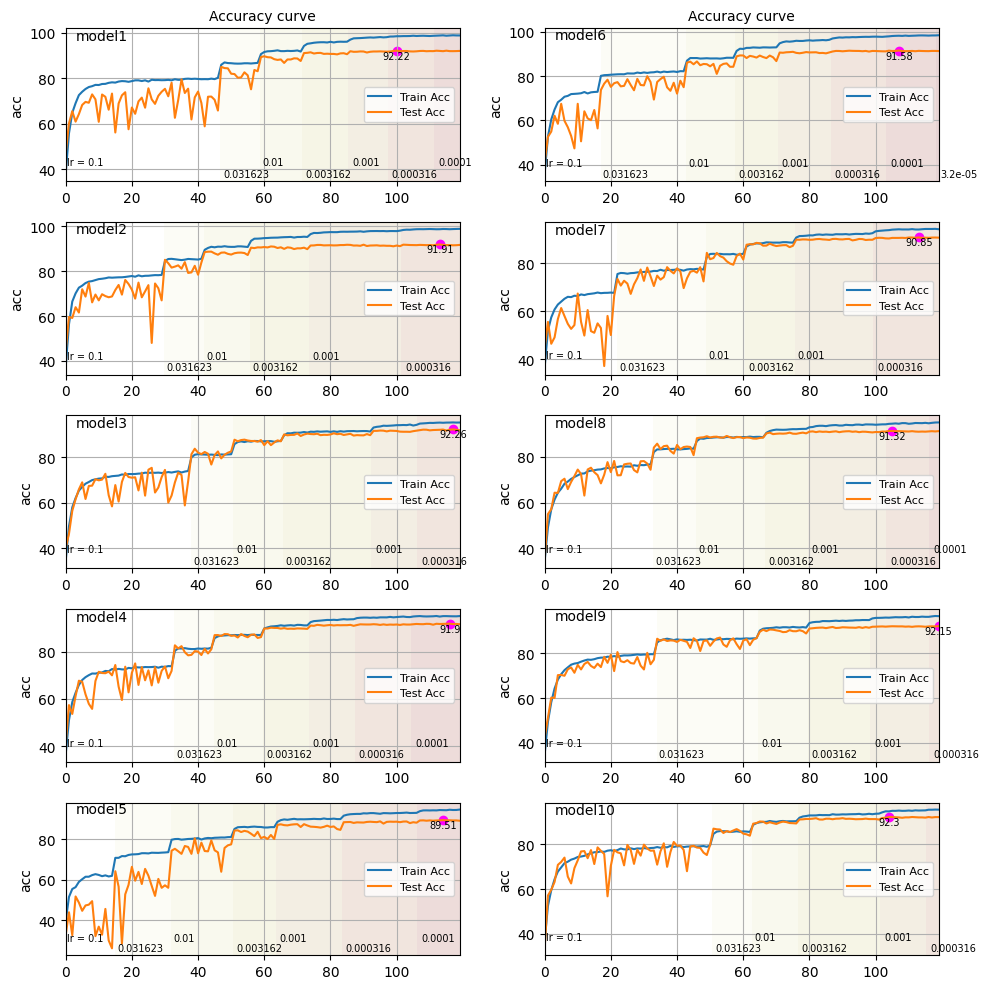

In [27]:
num_models = 10
num_epochs = 120

models = torch.load('./checkpoint_ensemble10/ckpt.pth', map_location=device)
xax = range(num_epochs)
fig, axs = plt.subplots(5, 2, figsize=(10,10))
for i in range(num_models):
    loc = (i % 5, (np.floor(i/5)).astype(int))
    axs[loc].plot(xax, models["model"+str(i+1)]["train_acc"], label="Train Acc")
    axs[loc].plot(xax, models["model"+str(i+1)]["test_acc"], label="Test Acc")
    best_epoch, best_val = np.argmax(models["model"+str(i+1)]["test_acc"]), max(models["model"+str(i+1)]["test_acc"])
    axs[loc].scatter(best_epoch, best_val, marker="o", c="magenta")
    axs[loc].text(best_epoch, best_val, round(best_val, 2), va="top", ha="center", fontsize=7)
    axs[loc].text(3, axs[loc].get_ylim()[1] - 5, "model"+str(i+1))
    if loc[0] == 0:
        axs[loc].set_title('Accuracy curve', fontsize=10)
    if loc[1] == num_models-1:
        axs[loc].set_xlabel('epoch')
    axs[loc].set_ylabel('acc')
    axs[loc].grid()
    axs[loc].legend(loc="center right", fontsize=8)
    lr = models["model"+str(i+1)]["lr"]
    axs[loc].pcolorfast(xax, axs[loc].get_ylim(), np.log(np.array(lr))[np.newaxis], cmap="pink", alpha=0.3, vmax=np.log(1e-1), vmin=np.log(1e-6))
    l = 1
    b = True
    for j in xax:
        if lr[j] != l:
            l = lr[j]
            if j == 0:
                axs[loc].text(j+0.5, axs[loc].get_ylim()[0]+(b*5+1), f"lr = {round(l,6)}", fontsize=7, va="bottom")
            else:
                axs[loc].text(j+0.5, axs[loc].get_ylim()[0]+(b*5+1), f"{round(l,6)}", fontsize=7, va="bottom")
            b = not b
fig.tight_layout()
fig.show()

Few observations. Compared with the 5-model ensembling, each model has less parameters, resulting in a bit worse test accuracy. Also, some models had a rough fluctuation in test accuracy in early steps. One possible reason for this is we introduced several augmentation techniques.

## 8. Ensembling 2 -- ten models ensembling --
Let's start with the majority vote.

In [29]:
models = torch.load('./checkpoint_ensemble10/ckpt.pth', map_location=device)
model = ResNet(BasicBlock, [2,2,2,2]).to(device)
if device=='cuda':
    model = torch.nn.DataParallel(model)
pred_dict, target_dict = {}, {}
pred_dict["train"], pred_dict["test"] = {}, {}
target_dict["train"], target_dict["test"] = np.array([], dtype=np.int8), np.array([], dtype=np.int8)
for i in range(num_models):
    pred_dict["train"]["model"+str(i+1)] = np.array([], dtype=np.float64).reshape(0,10)
    pred_dict["test"]["model"+str(i+1)] = np.array([], dtype=np.float64).reshape(0,10)
with torch.no_grad():
    for (inputs, targets) in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        for i in range(num_models):
            model.load_state_dict(models["model"+str(i+1)]["model"])
            model.eval()
            outputs = torch.nn.Softmax(dim=1)(model(inputs))
            pred_dict["train"]["model"+str(i+1)] = np.vstack([pred_dict["train"]["model"+str(i+1)], outputs.cpu().detach().numpy()])
            if i == 0:
                target_dict["train"] = np.hstack([target_dict["train"], targets.cpu().detach().numpy()])
    for (inputs, targets) in testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        for i in range(num_models):
            model.load_state_dict(models["model"+str(i+1)]["model"])
            model.eval()
            outputs = torch.nn.Softmax(dim=1)(model(inputs))
            pred_dict["test"]["model"+str(i+1)] = np.vstack([pred_dict["test"]["model"+str(i+1)], outputs.cpu().detach().numpy()])
            if i == 0:
                target_dict["test"] = np.hstack([target_dict["test"], targets.cpu().detach().numpy()])

In [30]:
from collections import Counter
import random
train_pred = np.array([], dtype=np.int8).reshape(0,50000)
test_pred = np.array([], dtype=np.int8).reshape(0,10000)
for i in range(num_models):
    train_pred = np.vstack([train_pred, np.argmax(pred_dict["train"]["model"+str(i+1)], axis=1)])
    test_pred = np.vstack([test_pred, np.argmax(pred_dict["test"]["model"+str(i+1)], axis=1)])
train_vote, test_vote = [], []
train_ties, test_ties = {"false": 0, "2": 0, "3": 0, "4": 0, "5": 0, "10": 0}, {"false": 0, "2": 0, "3": 0, "4": 0, "5": 0, "10": 0}
train_rand_choice, test_rand_choice = [], []
for i in range(len(train_pred[0])):
    c = Counter(train_pred[:, i]).most_common(num_models)
    if len(c) > 1 and c[0][1] == c[1][1]:
        cand = []
        for cnt in c:
            if cnt[1] == c[0][1]:
                cand.append(cnt[0])
        if target_dict["train"][i] in cand:
            train_ties[str(len(cand))] += 1
        else:
            train_ties["false"] += 1
        train_vote.append(-1)
        train_rand_choice.append(random.choice(cand))
    else:
        train_vote.append(c[0][0])
for i in range(len(test_pred[0])):
    c = Counter(test_pred[:, i]).most_common(num_models)
    if len(c) > 1 and c[0][1] == c[1][1]:
        cand = []
        for cnt in c:
            if cnt[1] == c[0][1]:
                cand.append(cnt[0])
        if target_dict["test"][i] in cand:
            test_ties[str(len(cand))] += 1
        else:
            test_ties["false"] += 1
        test_vote.append(-1)
        test_rand_choice.append(random.choice(cand))
    else:
        test_vote.append(c[0][0])
print(f"The number of ties in the training data: {sum(train_ties.values())}")
print(f"The number of ties in the test data: {sum(test_ties.values())}")
train_vote = np.array(train_vote)
test_vote = np.array(test_vote)
num_train_true = sum(train_vote==target_dict["train"]) + train_ties["2"] / 2 + train_ties["3"] / 3 \
                                + train_ties["4"] / 4 + train_ties["5"] / 5 + train_ties["10"] / 10
num_test_true = sum(test_vote==target_dict["test"]) + test_ties["2"] / 2 + test_ties["3"] / 3 \
                                + test_ties["4"] / 4 + test_ties["5"] / 5 + test_ties["10"] / 10
train_acc = num_train_true / len(train_vote) * 100
test_acc = num_test_true / len(test_vote) * 100
print(f"The training accuracy in expectation: {round(train_acc, 2)}%")
print(f"The test accuracy in expectation: {round(test_acc, 2)}%")
train_vote[train_vote==-1] = train_rand_choice
test_vote[test_vote==-1] = test_rand_choice

The number of ties in the training data: 112
The number of ties in the test data: 128
The training accuracy in expectation: 99.51%
The test accuracy in expectation: 94.06%


Compared to 5-model case where we got 94.41%, the result of 10-model came a little short with <b>94.06</b>% test accuracy. However, the best accuracy of each predictor is 92.30% by the model-10. Again, the mass of predictors beat the best one among them. <br>
Next, check the performance of averaging out method.

In [33]:
train_avg_pred = np.zeros((50000, 10))
test_avg_pred = np.zeros((10000, 10))
for i in range(num_models):
    train_avg_pred = train_avg_pred + pred_dict["train"]["model"+str(i+1)]
    test_avg_pred = test_avg_pred + pred_dict["test"]["model"+str(i+1)]
train_index = np.argpartition(train_avg_pred.T, -2, axis=0)[-2:]
test_index = np.argpartition(test_avg_pred.T, -2, axis=0)[-2:]
train_acc = sum(train_index[1]==target_dict["train"]) / len(train_avg_pred) * 100
test_acc = sum(test_index[1]==target_dict["test"]) / len(test_avg_pred) * 100
print(f"The training accuracy: {round(train_acc, 2)}%")
print(f"The test accuracy: {round(test_acc, 2)}%")

num_false_train = sum(train_index[1]!=target_dict["train"])
num_false_test = sum(test_index[1]!=target_dict["test"])
num_second_train = sum(train_index[0]==target_dict["train"])
num_second_test = sum(test_index[0]==target_dict["test"])
print(f"Out of {num_false_train} misclassified training cases, {num_second_train} cases have correct prediction in the second candidate.")
print(f"Out of {num_false_test} misclassified test cases, {num_second_test} cases have correct prediction in the second candidate.")

The training accuracy: 99.6%
The test accuracy: 94.23%
Out of 200 misclassified training cases, 180 cases have correct prediction in the second candidate.
Out of 577 misclassified test cases, 418 cases have correct prediction in the second candidate.


The accuracy improves to <b>94.23%</b> from 94.06% by the majority vote. However, 5-model ensembling gave better accuracy of 94.47%.